<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/7_3_Quantitative_Structure_Activity_Relationship_Studies_(QSAR)__Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Construction of a QSAR model**

---

Made by: Brayan Raziel Cedillo González and Karen Pelcastre

Contact: brayanraziel1997@gmail.com

**Last Update:** March 2025




The workflow described below includes the experiences and work of Dr. Pat Walters, available in his repository (https://github.com/PatWalters/practical_cheminformatics_tutorials).
In this script, it is possible to modify the entry format, descriptor or machine learning model changing only one code line. It is important to consider that this code doesn't replace a thorough validation, but it provides an agile starting point.


Before running this codebook the curation of the database and SMILES standarization is needed.

#Content
---




>[Construction of a QSAR model](#scrollTo=c11acc27)

>[Content](#scrollTo=XRc_s5HuPS01)

>[Introduction](#scrollTo=RPa9LY0L6EIJ)

>[1. Read files.](#scrollTo=41037477)

>[2. Selection of descriptors.](#scrollTo=8488ccfb)

>[3. Molecules transformation(molfeat).](#scrollTo=98a1b30f)

>[4. Fingerprints calculations.](#scrollTo=6bda1548)

>[5. Data segmentation: trial and trainning.](#scrollTo=ec6f5322)

>[6. Regressor (sklearn).](#scrollTo=d0ff42cd)

>[7. Construction and visualization of the model.](#scrollTo=P6P6syzp5IHi)

>[8. Residuals](#scrollTo=ec329324)

>[9. Prediction](#scrollTo=ssxjXMkoC_ai)

>[For more information:](#scrollTo=HwmLjnO6gNHJ)



<a name='0'></a>
# Introduction
---

In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random, subprocess, statistics
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(20)
        !pip install rdkit, pandas
        !pip install datamol # Library to work with molecular data, like chemical molecules and chemical data sets
        !pip install molfeat # Center of molecular characteristics generators
        !pip install numpy
        !pip install sklearn # ML library de ML, that provides tools for classification, regression, clustering and selecting models
        !pip install yellowbrick # Library to visualize ML
        pbar.update(30)
        import pandas as pd
        import datamol as dm
        from molfeat.calc import FPCalculator # Use to calculate molecular descriptors
        from molfeat.trans import MoleculeTransformer # Use to transform molecules applying certain operations
        from molfeat.calc import FP_FUNCS # Use to calculate fingerprints
        pbar.update(30)
        import numpy as np
        from sklearn.model_selection import train_test_split # Use to split a set of data into a trainning set and a trial set
        from sklearn.ensemble import HistGradientBoostingRegressor # It is an implementation of Gradient Boosting for regression problems in scikit-learn.
        from yellowbrick.regressor import prediction_error, residuals_plot # Use to (1) visualize and (2) plot prediction errors in regression problems

        #RDKit
        !pip install rdkit
        from rdkit import Chem, DataStructs
        from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, Descriptors3D, rdMolDescriptors, Scaffolds
        PandasTools.RenderImagesInAllDataFrames(images=True) # Visualize molecules
        from rdkit.Chem.Draw import IPythonConsole

        pbar.update(20)

  0%|          | 0/100 [00:00<?, ?it/s]


#*1. Read files.*
The file (csv or xlsx) that has the information of the molecules of interest (SMILES, ID/NAME, property) will be read.

Example:
```
filename ="https://raw.githubusercontent.com/PatWalters/yamc/main/data/Carbonic.smi"
df = pd.read_csv(filename,sep=" ",names=["SMILES","Name","pIC50"])
```



In [ ]:
#Read file
url = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets/compounds_ChEMBL_G9a.csv"
df = pd.read_csv(url, index_col=0)
df.head(5)

molecule_chembl_id                                             SMILES  \
0      CHEMBL4170225  COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)[nH]c...   
1      CHEMBL4162206  COc1cc2c(=NC3CCN(C(C)C)CC3)cc(C3CCCCC3)[nH]c2c...   
2      CHEMBL3109639               COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C   
3      CHEMBL3109631             COc1cc2c(cc1OCC1CCN(C)C1)N=C(N)C21CCC1   
4      CHEMBL5187766              COc1cc2c(=NCCN)cc[nH]c2cc1OCCCN1CCCC1   

      pIC50  
0  9.301030  
1  9.154902  
2  9.045757  
3  9.000000  
4  8.795880

molecule_chembl_id                                             SMILES  \
0      CHEMBL4170225  COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)[nH]c...   
1      CHEMBL4162206  COc1cc2c(=NC3CCN(C(C)C)CC3)cc(C3CCCCC3)[nH]c2c...   
2      CHEMBL3109639               COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C   

      pIC50                                             ROMol  
0  9.301030  <rdkit.Chem.rdchem.Mol object at 0x7fe4cef52420>  
1  9.154902  <rdkit.Chem.rdchem.Mol object at 0x7fe4cef52dc0>  
2  9.045757  <rdkit.Chem.rdchem.Mol object at 0x7fe4cef526c0>
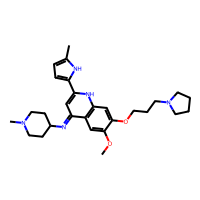
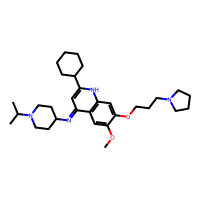
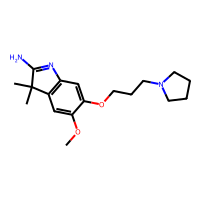

In [ ]:
df_visualization=df.copy()
df_visualization['ROMol'] = df_visualization['SMILES'].apply(Chem.MolFromSmiles)
df_visualization[0:3]

<a name='2'></a>
# *2. Selection of descriptors.*
We use the [molfeat](https://github.com/datamol-io/molfeat) package, which has multiple types of descriptors.

In [ ]:
print(f'Fingerprints that can be calculated:') #Descriptors that can be calculated with this library
for i in FP_FUNCS:
    print(i)

Fingerprints that can be calculated:
maccs
avalon
pattern
layered
map4
secfp
erg
estate
avalon-count
ecfp
fcfp
topological
atompair
rdkit
ecfp-count
fcfp-count
topological-count
atompair-count
rdkit-count


In [ ]:
calc_ecfp = FPCalculator("ecfp") #Calculate ECFP4
calc_maccs = FPCalculator("maccs") #Calculate MACCS

<a name='3'></a>

#*3. Molecules transformation(molfeat).*

This object takes a list of SMILES as input and returns the selected descriptors. It is very flexible and it can be runned in parallel
[URL](https://molfeat-docs.datamol.io/stable/tutorials/types_of_featurizers.html)

In [ ]:
trans_ecfp = MoleculeTransformer(calc_ecfp)
trans_maccs = MoleculeTransformer(calc_maccs)

<a name='4'></a>

# *4. Fingerprints calculations.*
Consider the use of the [datamol](https://datamol.io) function, that mutes the register of the RDKit messages. This is a more amicable version of the `rd_shut_the_hell_up` function in [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils).

In [ ]:
%%time
with dm.without_rdkit_log():
    df['fp_ecfp'] = trans_ecfp.transform(df.SMILES.values)
    df['fp_maccs'] = trans_maccs.transform(df.SMILES.values)

print(df.shape)
df.head(10)

(430, 5)
CPU times: user 981 ms, sys: 6.8 ms, total: 987 ms
Wall time: 987 ms


molecule_chembl_id                                             SMILES  \
0      CHEMBL4170225  COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)[nH]3)[nH]c...   
1      CHEMBL4162206  COc1cc2c(=NC3CCN(C(C)C)CC3)cc(C3CCCCC3)[nH]c2c...   
2      CHEMBL3109639               COc1cc2c(cc1OCCCN1CCCC1)N=C(N)C2(C)C   
3      CHEMBL3109631             COc1cc2c(cc1OCC1CCN(C)C1)N=C(N)C21CCC1   
4      CHEMBL5187766              COc1cc2c(=NCCN)cc[nH]c2cc1OCCCN1CCCC1   
5      CHEMBL4160008  CCc1ccc(-c2cc(=NC3CCN(C)CC3)c3cc(OC)c(OCCCN4CC...   
6      CHEMBL1829295  COc1cc2c(=NC3CCN(C(C)C)CC3)[nH]c(N3CCCN(C(C)C)...   
7      CHEMBL4159604  COc1cc2c(=NC3CCN(C)CC3)cc(C3CCCCC3)[nH]c2cc1OC...   
8      CHEMBL5195846                 COc1cc2c(=N)cc[nH]c2cc1OCCCN1CCCC1   
9      CHEMBL4173626  CCc1ccc(-c2cc(=NC3CCN(C(C)C)CC3)c3cc(OC)c(OCCC...   

      pIC50                                            fp_ecfp  \
0  9.301030  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
1  9.154902  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
2  9.045757  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
3  9.000000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  8.795880  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
5  8.698970  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
6  8.698970  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
7  8.698970  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
8  8.619789  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
9  8.522879  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   

                                            fp_maccs  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

#*5. Data segmentation: trial and trainning.*
It is a good option to make it with dataframes, since this way you don't have to remember the order in which the informtaion is retrieved (trainning_x, trial_x,trainning_y y trial_y) with[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
train, test = train_test_split(df, test_size=0.3, train_size=0.7, random_state=1) #Common metric 70:30
train.head(8)

molecule_chembl_id                                             SMILES  \
299        CHEMBL55934                              O=C1C=CC(=O)c2ccccc21   
320      CHEMBL4472432        N=C1Nc2cc(OCCCN3CCCC3)c(OCC3CC3)cc2C12CCCC2   
417      CHEMBL1213827  COc1cc2c(=NC3CCN(C)CC3)[nH]c(N3CCCN(C)CC3)nc2c...   
207      CHEMBL4063767   CCCN(CC)c1nc(=NC2CCN(C)CC2)c2cc(OC)c(OC)cc2[nH]1   
127      CHEMBL4279738  COc1cc2[nH]c(N3CCC(OC)CC3)cc(=NC3CCN(Cc4ccccc4...   
82       CHEMBL1829307  COc1cc2c(=NC3CCN(C(C)C)CC3)[nH]c(N3CCCCCC3)nc2...   
392      CHEMBL3238424  O=C(O)c1cccc(NCc2cccc(-n3ccc4c(-c5ccc(C(F)(F)F...   
146      CHEMBL4100004  COc1cc2[nH]c(N(C)C3CCCCC3)nc(=NC3CCN(C)CC3)c2c...   

        pIC50                                            fp_ecfp  \
299  5.698970  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
320  5.508638  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
417  3.853872  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...   
207  6.317855  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
127  6.924453  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
82   7.508638  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
392  4.578396  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
146  6.752027  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                              fp_maccs  
299  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
320  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
417  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...  
207  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
127  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
82   [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
392  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
146  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
test

molecule_chembl_id                                             SMILES  \
227      CHEMBL2172426  CN1C(=O)C23CC4(C56CC78SSC(C)(C(=O)N7C5Nc5ccccc...   
208      CHEMBL4072358     COc1cc2[nH]c(N(C)CCCO)nc(=NC3CCN(C)CC3)c2cc1OC   
164      CHEMBL4873711  COc1cc2c(=NCC3CCN(c4ccc(C(O)=NO)cc4)CC3)cc(-c3...   
277      CHEMBL3943729   O=C1c2ccccc2-c2onc3c(N4CCCC4)cc(NCCN4CCCC4)c1c23   
62       CHEMBL4167925  COc1cc2c(=NC3CCN(C)CC3)cc(C3CCOCC3)[nH]c2cc1OC...   
..                 ...                                                ...   
379      CHEMBL4290963  COc1cc2c(=NC3CCN(Cc4ccccc4)CC3)[nH]c(N3CCN(C)C...   
139      CHEMBL4167876  COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(CN(C)C)o3)[nH...   
98       CHEMBL4159955  CCNCc1ccc(-c2cc(=NC3CCN(C)CC3)c3cc(OC)c(OCCCN4...   
361      CHEMBL4576128  CCOc1cc2c(=NC3CCN(C(C)C)CC3)[nH]c(C3CCCCC3)nc2...   
305      CHEMBL3926539  O=C1c2ccccc2-c2onc3c(N4CCCCC4)cc(NCCN4CCCC4)c1c23   

        pIC50                                            fp_ecfp  \
227  6.200659  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
208  6.315155  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
164  6.570248  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
277  5.913640  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
62   7.769551  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
..        ...                                                ...   
379  5.000000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
139  6.829738  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
98   7.318759  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...   
361  5.209715  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
305  5.661544  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                              fp_maccs  
227  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
208  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
164  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
277  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
62   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
..                                                 ...  
379  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
139  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
98   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...  
361  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
305  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[129 rows x 5 columns]

<a name='6'></a>

#*6. Regressor (sklearn).*
Here we used
[HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)
that is the scikit-learn implementation of
[LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
. It can easily connect any compatible regressor with scikit-learn like [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) or [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)



```
from lightgbm import LGBMRegressor
model = LGBMRegressor()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
from xgboost import XGBRegressor
model = XGBRegressor()
```




In [ ]:
model = HistGradientBoostingRegressor()

<a name='7'></a>

#*7. Construction and visualization of the model.*
Use [YellowBrick](https://www.scikit-yb.org/en/latest/) to build the model and visualize its use. The reported **lost** in the following plot is the [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) for the model.

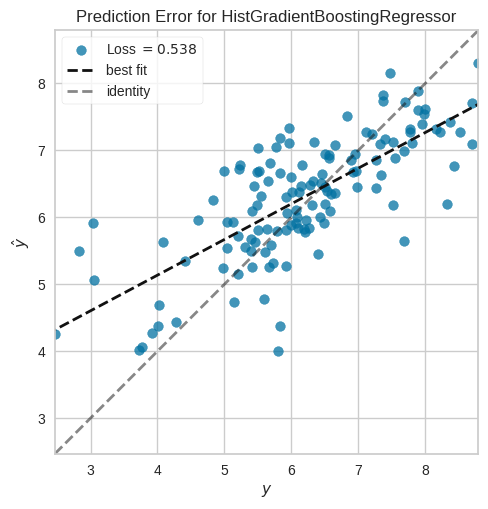

CPU times: user 4.07 s, sys: 1.43 s, total: 5.5 s
Wall time: 8.61 s


In [ ]:
%%time
visualizer = prediction_error(model,
                              X_train=np.stack(train.fp_maccs), y_train=train.pIC50,
                              X_test=np.stack(test.fp_maccs), y_test=test.pIC50)

A $R^2$ of X indicates that the model explains approximately the x% of the variability in the target variable in the trial set. This is considered:

1) Pretty good (if it's high) and suggests that the model has a good predictive ability.

2) Bad (if it's low) and suggests that the model has a bad predictive ability.



# *8. Residuals*
Plot the residuals of the training and trial set. The residuals are the difference between the real values of the target variable and the predictions made by the model. The residuals are a measure of how much predictions deviate from the real values. If a model is precise, the residuals should be near zero. A big difference between the $R^2$ of the training and trial could indicate an overfitting, where the model has been adapted too much to the specific training data and doesn't generalize correctly the new data.

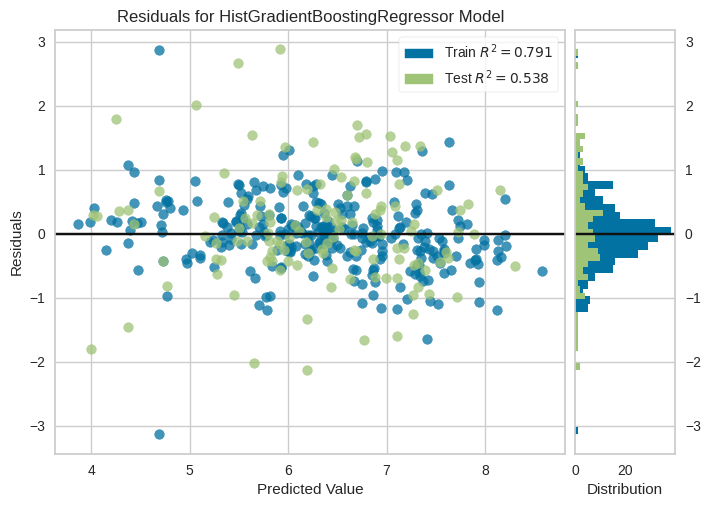

In [ ]:
viz = residuals_plot(model,np.stack(train.fp_maccs), train.pIC50, np.stack(test.fp_maccs), test.pIC50, is_fitted=True)

<a name='9'></a>
#*9. Prediction*


In [ ]:
#Read file
url = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Datasets/Fingerprints.csv"
df_prediction = pd.read_csv(url)
df_prediction=df_prediction[['ID', 'smiles']]
df_prediction.head(5)

ID                                             smiles
0  CHEMBL3087498  Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...
1  CHEMBL2171169  O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...
2    CHEMBL83747  Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...
3  CHEMBL4215326  O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...
4  CHEMBL1201129         O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1

In [ ]:
df_prediction['fp'] = trans_maccs.transform(df_prediction.smiles.values)
df_prediction

ID                                             smiles  \
0          CHEMBL3087498  Brc1c2c(N)ncnc2n([C@]2[C@](O)[C@](O)[C@@](CN(C...   
1          CHEMBL2171169  O=C(NCCCN(C(C)C)C[C@@]1[C@@](O)[C@@](O)[C@](n2...   
2            CHEMBL83747  Brc1c(O)ccc(C/C(=N\O)/C(=O)NCCSSCCNC(=O)/C(=N/...   
3          CHEMBL4215326  O(C)c1c(OC2CC3(CN(C)C3)C2)cc2nc(-c3oc(C)cc3)cc...   
4          CHEMBL1201129         O=C1N([C@@]2O[C@](CO)[C@@](O)C2)C=NC(N)=N1   
..                   ...                                                ...   
194            F447-0397  S(=O)(=O)(Nc1cc2c(C(=O)O)cc(N3CCN(c4ccc(OC)cc4...   
195  FC.CSC.04E fr 16-20  Clc1cc(NS(=O)(=O)c2ccc(NS(=O)(=O)c3cc4c(cc3)cc...   
196      FC.CSC.10C fr 4       S(=O)(=O)(Nc1cc(OC)cc(OC)c1)c1cc2c(cc1)cccc2   
197                DLP18         O=C(Nc1nocc1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1   
198                DLP19         O=C(Nc1sccn1)CN1CCN(c2ccc(C(=O)OCC)cc2)CC1   

                                                    fp  
0    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
..                                                 ...  
194  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
195  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
196  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
197  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
198  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  

[199 rows x 3 columns]

In [ ]:
df_prediction['predicted_ic50'] = model.predict(np.stack(df_prediction.fp))
df_prediction=df_prediction.sort_values(by='predicted_ic50', ascending=False)
df_prediction

ID                                             smiles  \
60   CHEMBL4162206  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(C...   
99   CHEMBL1231795  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)nc(C...   
34   CHEMBL4173626  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(-...   
20   CHEMBL4204482  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CC4(C3)CCN(C(C)C)C...   
24   CHEMBL4171233  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(-...   
..             ...                                                ...   
148  CHEMBL4649221  Fc1cc(-c2nc(C3C(=O)c4c(N(CC(=O)Nc5cc6OCOc6cc5)...   
120   CHEMBL560768  Clc1nc(NCCc2ccc(-c3ccccc3)cc2)c2ncn([C@]3[C@](...   
140  CHEMBL3109084  S(N[C@](C(=O)O)Cc1c2c([nH]c1)cccc2)c1c([N+](=O...   
133  CHEMBL3126648  O=C(Nc1ccc(Nc2nc(N)nc(C)c2)cc1)c1c(Nc2c3c(ncc2...   
153  CHEMBL3126649  O=C(Nc1cc(Nc2nc(N)nc(C)c2)ccc1)c1c(Nc2c3c(ncc2...   

                                                    fp  predicted_ic50  
60   [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.416763  
99   [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.416763  
34   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.300118  
20   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.196466  
24   [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.165610  
..                                                 ...             ...  
148  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        4.337095  
120  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        4.329390  
140  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        4.327025  
133  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        4.263370  
153  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...        4.263370  

[199 rows x 4 columns]

ID                                             smiles  \
60  CHEMBL4162206  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(C...   
99  CHEMBL1231795  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)nc(C...   
34  CHEMBL4173626  O(CCCN1CCCC1)c1c(OC)cc2c(NC3CCN(C(C)C)CC3)cc(-...   

                                                   fp  predicted_ic50  \
60  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.416763   
99  [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.416763   
34  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...        7.300118   

                                               ROMol  
60  <rdkit.Chem.rdchem.Mol object at 0x7fe4cc68d000>  
99  <rdkit.Chem.rdchem.Mol object at 0x7fe4cc68da80>  
34  <rdkit.Chem.rdchem.Mol object at 0x7fe4cc68d930>
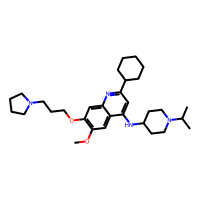
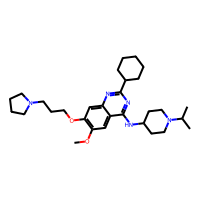
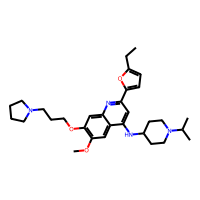

In [ ]:
df_prediction['ROMol'] = df_prediction['smiles'].apply(Chem.MolFromSmiles)#.apply(Chem.AddHs)
df_prediction[0:3]

---
# For more information:

*   Original Patt Walters script: https://colab.research.google.com/github/PatWalters/practical_cheminformatics_tutorials/blob/main/ml_models/QSAR_in_8_lines.ipynb
* Patt Walters GitHub blog: https://github.com/PatWalters/practical_cheminformatics_tutorials?tab=readme-ov-file


